A few simple experiments to see how bands and their masks are structured in the case of a hyperspectral file in Prisma. I am currently a bit confused about how these bands behave and we'll have to see. There are valid bands and invalid bands - where in an entire band is invalid. There are also valid and invalid pixels in a band. Will each band have the same set of valid and invalid pixels or does that change from band to band is the promary question we will try and answer here.

In [1]:
import pathlib
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Register the parent directory as a path to look for modules
notebook_dir = pathlib.Path().resolve()
parent_dir = notebook_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from app.utils.files.he5_helper import HE5Helper
from app.templates.template_mappings import TemplateIdentifier, TEMPLATE_MAPPINGS
from app.models.file_processing.sources import FileSourceConfig
from app.models.hyperspectral_concepts.spectral_family import SpectralFamily
from app.utils.image_transformation.image_cube_operations import ImageCubeOperations, CubeRepresentation

source = FileSourceConfig(
    source_path = "../tests/test_payloads/phase_2/Set-1/Hypersepctral Datasets/PRS_L2D_STD_20201214060713_20201214060717_0001.he5"
)

helper = HE5Helper(
    file_source_config=source,
    template = TEMPLATE_MAPPINGS.get(TemplateIdentifier.PRISMA_HYPERSPECTRAL)
)

In [25]:
a = helper.extract_error_matrices(
    bands = [1],
    spectral_family = SpectralFamily.SWIR,
    mode='all'
)

In [38]:
(a[:,159, :] > 0).sum()


np.int64(1850)

In [28]:
a.min()

np.uint8(0)

The first thing that we will do is pull out all the bands in the Prisma dataset and stack them. This means pulling out the VNIR and the SWIR cubes and then looking at them. We'll pull them out without the masks.

Points to note:
1. There is no constant template that defines a border mask, in each band, there are a different number of pixels that are considered to be invalid and hence masked. The invalid pixel mask thus has to be carefully constructed as a 3d cube and not a 2d template.
2. I dont think there is a need to have a seperate band mask and a invlaid pixel mask. All we need is just a very simple 3d cube that contains band level invalid pixels.


#### Experiment
Total 0 value pixels in the VNIR bands = 31025786
Total masked pixels in masked array output = 31025786

This makes sense - just counting 0's would be a good starting point. So, instead of a band level mask and a seperate invalid pixel mask, we can just have a masking cube, which will be enough.

#### Concatenating both VNIR and SWIR

In [34]:
cuber = ImageCubeOperations()
vnir_cubes = helper.extract_specific_bands(
    bands = [1],
    spectral_family=SpectralFamily.VNIR,
    mode = "all",
    masking_needed=True
)

vnir_cubes = cuber.convert_cube(
    cube = vnir_cubes, 
    from_format=CubeRepresentation.BIL,
    to_format = CubeRepresentation.BSQ
)

swir_cubes = helper.extract_specific_bands(
    bands = [1],
    spectral_family=SpectralFamily.SWIR,
    mode = "all",
    masking_needed=True
)

swir_cubes = cuber.convert_cube(
    cube = swir_cubes, 
    from_format=CubeRepresentation.BIL,
    to_format = CubeRepresentation.BSQ
)

stacked_cubes = np.ma.concatenate([vnir_cubes, swir_cubes], axis=0)
(stacked_cubes == 0).sum()

Using device: mps


np.int64(0)

One question is what is the common mask? This can be obtained by just a bit-wise AND operation on the masks across bands as shown below. This common mask can then be supplied as an additional channel in the input to the network.

423610


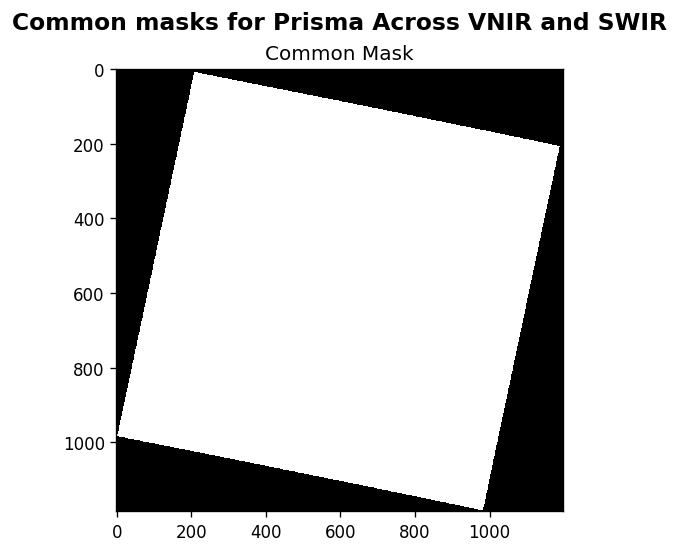

In [50]:
# Squashing together the masks which are common
common = np.bitwise_and.reduce(stacked_cubes.mask, axis = 0, keepdims=True)
fig, axes = plt.subplots(
    1,
    1,
    figsize=(4 * 3, 4.5 * 1),
    constrained_layout=True,
    dpi=120,
)

fig.suptitle(
            f"Common masks for Prisma Across VNIR and SWIR",
            fontsize=14,
            fontweight="bold",
        )
bw_map = ListedColormap(['white', 'black'])
axes.imshow(cuber.convert_cube(
    common, CubeRepresentation.BSQ, CubeRepresentation.BIP,
), cmap=bw_map, vmin=0, vmax=1, interpolation='nearest')
axes.set_title("Common Mask")
print(common.sum())



(1, 1186, 1196)
1233597


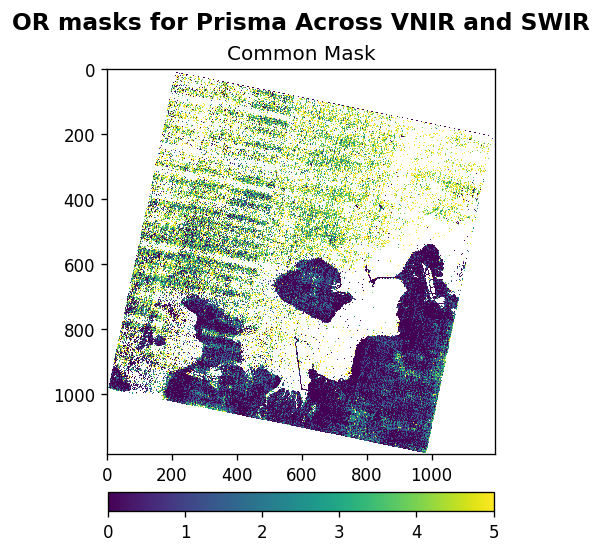

In [68]:
# Trying to generate masks that are basicall OR masks
validity = []
for i in range(stacked_cubes.data.shape[0]):
    band = stacked_cubes[i, : , :]
    if band.data.sum() == 0:
        continue
    validity.append(i)


valid_stacked_cubes = stacked_cubes[validity, : , :]
missing_counts = valid_stacked_cubes.mask.sum(axis = 0, keepdims = True)
print(missing_counts.shape)
common = np.bitwise_or.reduce(valid_stacked_cubes.mask, axis = 0, keepdims=True)

fig, axes = plt.subplots(
    1,
    1,
    figsize=(4 * 3, 4.5 * 1),
    constrained_layout=True,
    dpi=120,
)

fig.suptitle(
            f"OR masks for Prisma Across VNIR and SWIR",
            fontsize=14,
            fontweight="bold",
        )
bw_map = ListedColormap(['white', 'black'])
im = axes.imshow(cuber.convert_cube(
    np.ma.masked_where(missing_counts > 5, missing_counts), CubeRepresentation.BSQ, CubeRepresentation.BIP,
), cmap="viridis", interpolation='nearest')
axes.set_title("Common Mask")
cbar = fig.colorbar(
    im,
    ax=axes,
    orientation="horizontal",
    fraction=0.05,
    pad=0.02,
)

print(common.sum())



In [64]:
len(validity)

234